In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [9]:
data2 = pd.read_csv('all_synthetic_data2.csv')

In [10]:
def model(X, θ1, θ2):
    return θ1 * X + θ2

In [11]:
def mse(X, Y, θ1, θ2):
    predictions = model(X, θ1, θ2)
    return tf.reduce_mean(tf.square(predictions - Y))  # MSE formula

In [12]:
def u(x):
    return x

In [13]:
def discrimination_statistic(X, Y, T, θ1, θ2):
    residuals_t0 = model(X, θ1, θ2) - Y
    residuals_t1 = model(X, θ1, θ2) - Y

    # Conditional expectations (using mean as a proxy for E)
    exp_t0 = tf.reduce_mean(tf.gather(residuals_t0, tf.where(T == 0)))  # E[u] for T=0
    exp_t1 = tf.reduce_mean(tf.gather(residuals_t1, tf.where(T == 1)))  # E[u] for T=1
    
    return exp_t0 - exp_t1

In [122]:
# Gradient Descent Function
def gradient_descent(X, Y, T, θ1_init, θ2_init, λ, learning_rate, optimizer, iterations=200, clip_value=10):
    θ1 = tf.Variable(θ1_init, dtype=tf.float32)
    θ2 = tf.Variable(θ2_init, dtype=tf.float32)
    
    for i in range(iterations):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(θ1)
            tape.watch(θ2)

            λ = tf.cast(λ, tf.float32)
            scaled_lambda = 1 / (1 + tf.exp(-λ + 2))
            
        
            loss_value = mse(X, Y, θ1, θ2) + scaled_lambda * tf.abs(discrimination_statistic(X, Y, T, θ1, θ2))
        
        # Compute gradients
        gradients_θ1 = tape.gradient(loss_value, θ1)
        gradients_θ2 = tape.gradient(loss_value, θ2)
        
        # Gradient clipping
        gradients_θ1 = tf.clip_by_value(gradients_θ1, -clip_value, clip_value)
        gradients_θ2 = tf.clip_by_value(gradients_θ2, -clip_value, clip_value)

        # Update θ1 and θ2 using gradient descent
        θ1.assign_sub(learning_rate * gradients_θ1)
        θ2.assign_sub(learning_rate * gradients_θ2)
    
    return θ1.numpy(), θ2.numpy() #The .numpy() method is used to convert a TensorFlow tf.Variable (or tf.Tensor) to a regular NumPy array

In [123]:
num_trials = 10  # Number of trials
lambda_values = np.linspace(0, 10, 40)  # λ values from 0 to 10 (inclusive)

In [124]:
mse_results = np.zeros((len(lambda_values), num_trials))
d_theta_results = np.zeros((len(lambda_values), num_trials))

In [140]:
learning_rate = 0.007

In [141]:
optimizer = Adam(learning_rate=0.007,beta_1=0.70, beta_2=0.6, epsilon=1e-8)

In [144]:
for trial in range(num_trials):
    # Sample 100 data points for each trial
    sampled_data = data2.sample(n=100)
    X = sampled_data['X'].values
    Y = sampled_data['Y'].values
    T = sampled_data['T'].values
    
    θ1_init = np.random.randn() * 0.01
    θ2_init = np.random.randn() * 0.01
    
    for i, λ in enumerate(lambda_values):

        # Perform gradient descent optimization
        θ1_opt, θ2_opt = gradient_descent(X, Y, T, θ1_init, θ2_init, λ, learning_rate, optimizer, iterations=100, clip_value=10)
        
        # Store MSE and discrimination statistic results
        mse_results[i, trial] = mse(X, Y, θ1_opt, θ2_opt)
        d_theta_results[i, trial] = discrimination_statistic(X, Y, T, θ1_opt, θ2_opt)
    
        # Print MSE and Discrimination Statistic for each trial and λ
        print(f"λ = {λ:.2f}, Trial {trial + 1}: MSE = {mse_results[i, trial]:.4f}, Discrimination Statistic = {d_theta_results[i, trial]:.4f}")
    
    # Print a separator between λ values
    print('-' * 50)

λ = 0.00, Trial 1: MSE = 0.7631, Discrimination Statistic = -0.7260
λ = 0.26, Trial 1: MSE = 0.7655, Discrimination Statistic = -0.7036
λ = 0.51, Trial 1: MSE = 0.7694, Discrimination Statistic = -0.6767
λ = 0.77, Trial 1: MSE = 0.7750, Discrimination Statistic = -0.6452
λ = 1.03, Trial 1: MSE = 0.7832, Discrimination Statistic = -0.6090
λ = 1.28, Trial 1: MSE = 0.7944, Discrimination Statistic = -0.5683
λ = 1.54, Trial 1: MSE = 0.8091, Discrimination Statistic = -0.5239
λ = 1.79, Trial 1: MSE = 0.8275, Discrimination Statistic = -0.4769
λ = 2.05, Trial 1: MSE = 0.8494, Discrimination Statistic = -0.4286
λ = 2.31, Trial 1: MSE = 0.8741, Discrimination Statistic = -0.3806
λ = 2.56, Trial 1: MSE = 0.9008, Discrimination Statistic = -0.3345
λ = 2.82, Trial 1: MSE = 0.9282, Discrimination Statistic = -0.2914
λ = 3.08, Trial 1: MSE = 0.9550, Discrimination Statistic = -0.2525
λ = 3.33, Trial 1: MSE = 0.9804, Discrimination Statistic = -0.2181
λ = 3.59, Trial 1: MSE = 1.0035, Discrimination 

In [145]:
mean_mse = np.mean(mse_results, axis=1)  # Mean along columns (i.e., over trials)
mean_d_theta = np.mean(d_theta_results, axis=1)  # Mean along columns (i.e., over trials)
d_theta_std = np.std(d_theta_results, axis=1)
mse_std = np.std(mse_results, axis=1)

In [146]:
for i, λ in enumerate(lambda_values):
    print(f"λ = {λ:.2f} -> Mean MSE = {mean_mse[i]:.4f}, Mean Discrimination Statistic = {mean_d_theta[i]:.4f}")

λ = 0.00 -> Mean MSE = 0.6938, Mean Discrimination Statistic = -0.6367
λ = 0.26 -> Mean MSE = 0.6955, Mean Discrimination Statistic = -0.6182
λ = 0.51 -> Mean MSE = 0.6983, Mean Discrimination Statistic = -0.5960
λ = 0.77 -> Mean MSE = 0.7026, Mean Discrimination Statistic = -0.5700
λ = 1.03 -> Mean MSE = 0.7088, Mean Discrimination Statistic = -0.5401
λ = 1.28 -> Mean MSE = 0.7174, Mean Discrimination Statistic = -0.5065
λ = 1.54 -> Mean MSE = 0.7289, Mean Discrimination Statistic = -0.4699
λ = 1.79 -> Mean MSE = 0.7433, Mean Discrimination Statistic = -0.4311
λ = 2.05 -> Mean MSE = 0.7606, Mean Discrimination Statistic = -0.3912
λ = 2.31 -> Mean MSE = 0.7802, Mean Discrimination Statistic = -0.3516
λ = 2.56 -> Mean MSE = 0.7986, Mean Discrimination Statistic = -0.3183
λ = 2.82 -> Mean MSE = 0.8171, Mean Discrimination Statistic = -0.2880
λ = 3.08 -> Mean MSE = 0.8386, Mean Discrimination Statistic = -0.2551
λ = 3.33 -> Mean MSE = 0.8546, Mean Discrimination Statistic = -0.2329
λ = 3.

In [152]:
lambda_threshold_idx = np.where(np.abs(mean_d_theta) < 0.15)[0]
if len(lambda_threshold_idx) > 0:
    lambda_threshold = lambda_values[lambda_threshold_idx[0]]
else:
    lambda_threshold = None

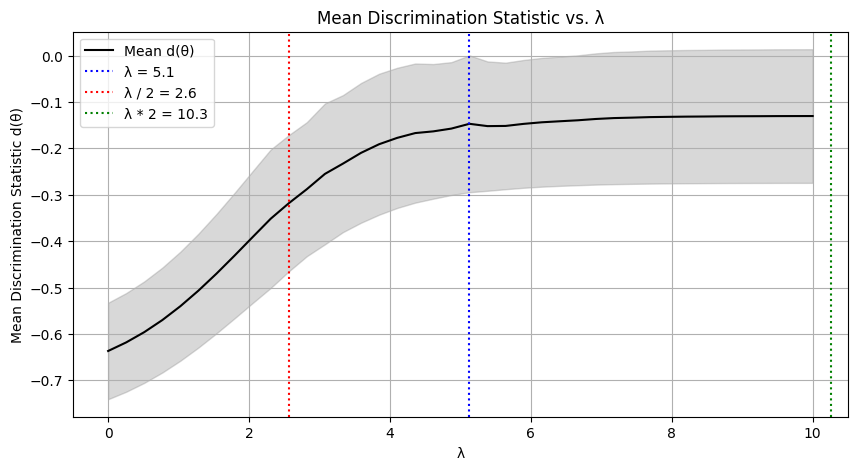

In [153]:
# Plot Mean Discrimination Statistic vs. λ
plt.figure(figsize=(10, 5))
plt.plot(lambda_values, mean_d_theta, color='black', label='Mean d(θ)')
plt.fill_between(lambda_values, mean_d_theta - d_theta_std, mean_d_theta + d_theta_std, color='gray', alpha=0.3)
if lambda_threshold is not None:
    plt.axvline(lambda_threshold, color='blue', linestyle='dotted', label=f'λ = {lambda_threshold:.1f}')
    plt.axvline(lambda_threshold / 2, color='red', linestyle='dotted', label=f'λ / 2 = {lambda_threshold / 2:.1f}')
    plt.axvline(lambda_threshold * 2, color='green', linestyle='dotted', label=f'λ * 2 = {lambda_threshold * 2:.1f}')
plt.xlabel('λ')
plt.ylabel('Mean Discrimination Statistic d(θ)')
plt.title('Mean Discrimination Statistic vs. λ')
plt.legend()
plt.grid(True)
plt.show()

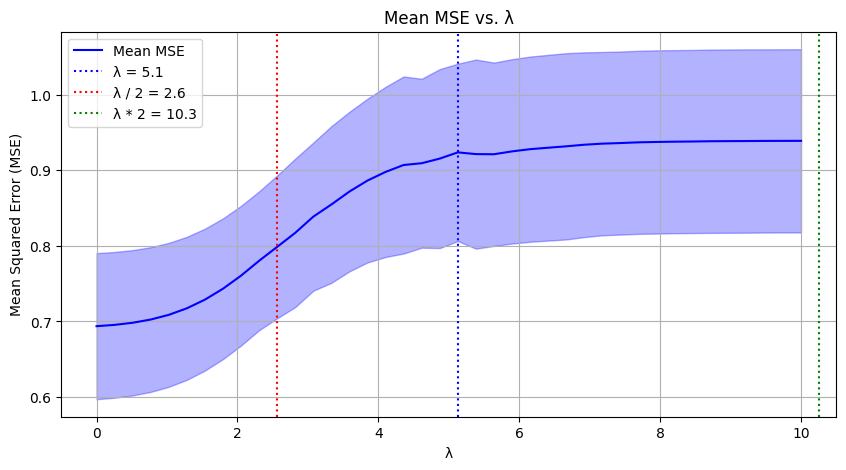

In [154]:
# Plot Mean MSE vs. λ
plt.figure(figsize=(10, 5))
plt.plot(lambda_values,mean_mse, color='blue', label='Mean MSE')
plt.fill_between(lambda_values,mean_mse - mse_std,mean_mse + mse_std, color='blue', alpha=0.3)
if lambda_threshold is not None:
    plt.axvline(lambda_threshold, color='blue', linestyle='dotted', label=f'λ = {lambda_threshold:.1f}')
    plt.axvline(lambda_threshold / 2, color='red', linestyle='dotted', label=f'λ / 2 = {lambda_threshold / 2:.1f}')
    plt.axvline(lambda_threshold * 2, color='green', linestyle='dotted', label=f'λ * 2 = {lambda_threshold * 2:.1f}')
plt.xlabel('λ')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean MSE vs. λ')
plt.legend()
plt.grid(True)
plt.show()